# 딥러닝을 이용한 사물이미지의 분류

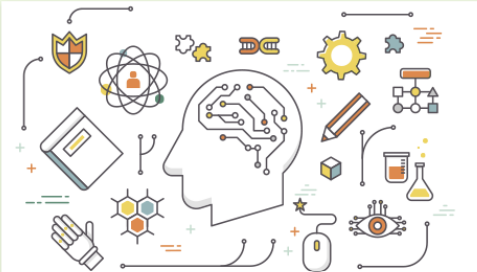

#1조 
##김명진
##구성봉
##박수영



---



I. 서론

 프로젝트 기획 배경 및 목표

II.본론

 1.기본 구조 
 
 2.증강

  1) 단순 증강 

  2) 증강 + 믹스업

  3) 증강 + 믹스업 + cnn 깊이 변경 

 3.전이

  1)VGG16

  2)Rsnet50

  3)전이+증강

  * 14종류별 모델비교  
  * 성능 좋은 모델 구현

III.결론

 1.분석 결과 

 2.향후개선 사항 및 아쉬운 점

 










---



#I. 프로젝트 기획 배경 및 목표


1. 10개의 class 이미지 데이터를 딥러닝으로 사물인식 및 이미지 분류의 최적의 방법을 모색

2. CNN의 폭넓은 이해와 지식을 위해 실제 모델 구현 

3. CNN의 다양한 종류를 알아보고 비교를 통하여 성능 및 차이점을 분석

4. 데이콘에 출전하여 상위 15%안에 랭킹

5. 데이콘에는 사전학습으로 출전 불가하기 때문에 출전용으로는 증강기법을 포커스로 하여 확률을 높임 







#II.CNN 이란



*   Convolutional Neural Network, 합성곱 신경망

*   인간의 시신경 구조를 모방한 기술

* 일반 Deep Neural Network에서 이미지나 영상과 같은 데이터를 처리할 때 발생하는 문제점들을 보완한 방법





#1.기본구조 설명

##1.1 라벨확인

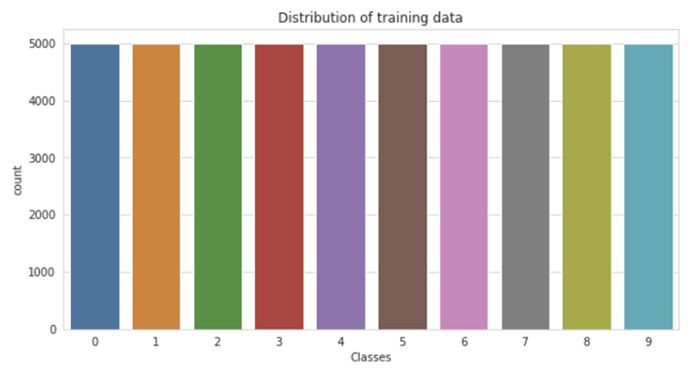

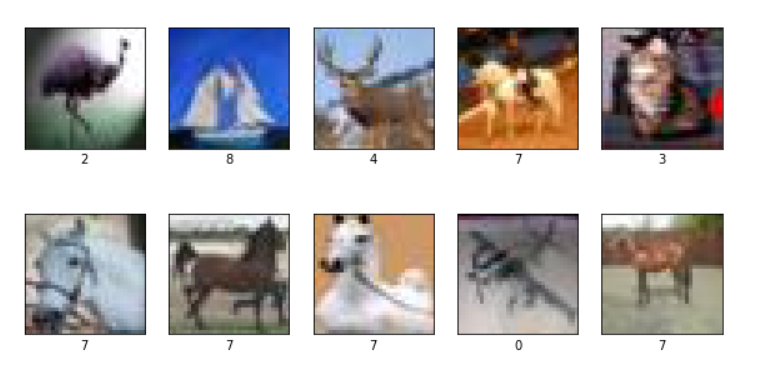

##1.2 CNN 기본 구조 

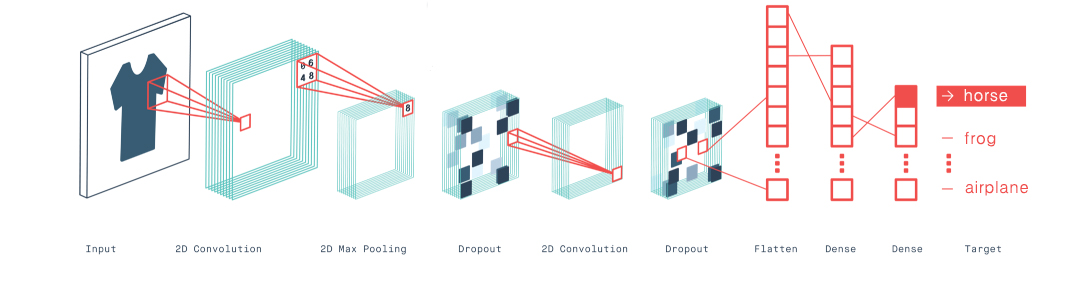

##1.3 모델설계 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    tf.keras.layers.Dropout(0.23),  # 무작위로 퍼셉트론 비활성화(23%)
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(1024, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [ ]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


*  활성화 함수는 softmax를 layer 에서 class 별 확률을 출력하기 위해 사용하였다.

* 라벨이 정수의 형태이기 때문에 손실함수는       sparse_categorical_crossentropy, 최적화 함수는 adam을 이용하였다.




##1.4  train/validation acc,loss 그래프 

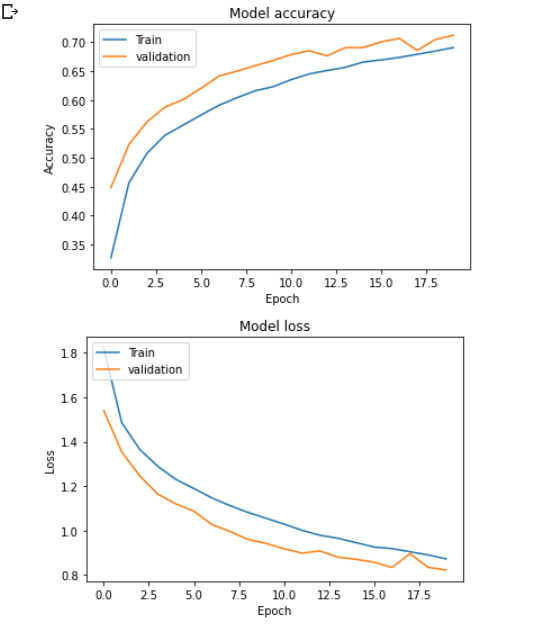

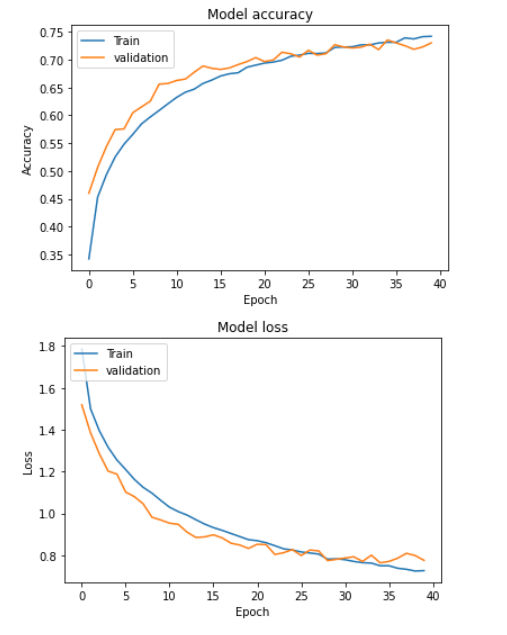

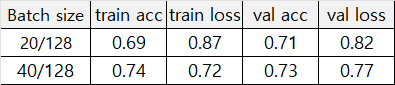

* 대체적으로 accuracy보다 loss 확률이 큰 형상을 보이기 때문에 증강 방식으로 적합한 방법을 찾기로 한다.

#2.증강

##2.1 단순증강

증강은 data set의 개수를 늘려서 overfitting을 해결하기 위해 등장한 개념이다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=30,
    brightness_range = [0.8, 1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

* rotation_range : 이미지를 랜덤한 각도로 돌리는 정도

* brightness_range : 이미지의 밝기를 랜덤하게 다르게 주는 정도

* zoom_range : 사진을 확대하는 정도

* width_shift_range : 사진을 왼쪽 오른쪽으로 움직이는 정도

* height_shift_range : 사진을 위 아래로 움직이는 정도

* horizontal_flip : y축을 기준으로 반전 (오른쪽 왼쪽 뒤집기)


###2.1.1증식 샘플 확인 

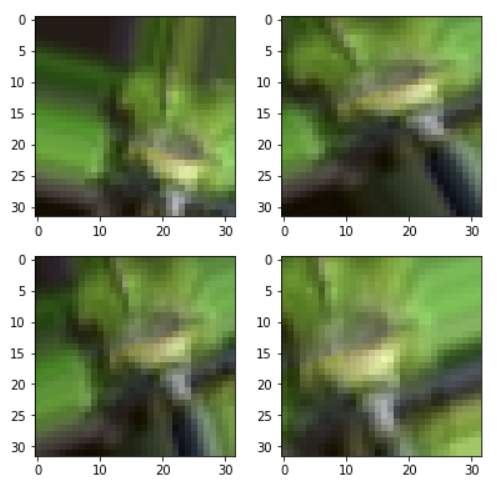

###2.1.2 증식 결과

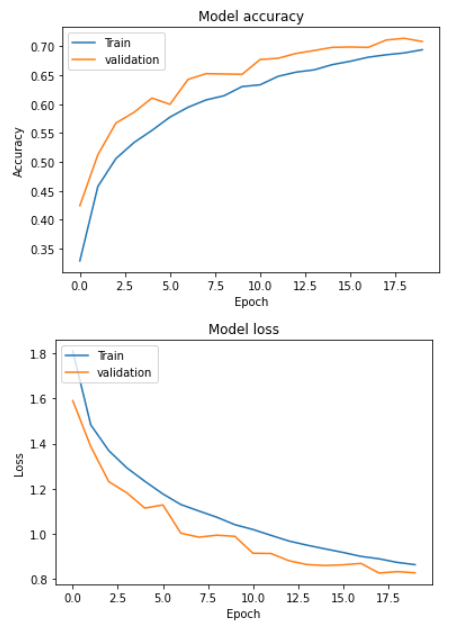

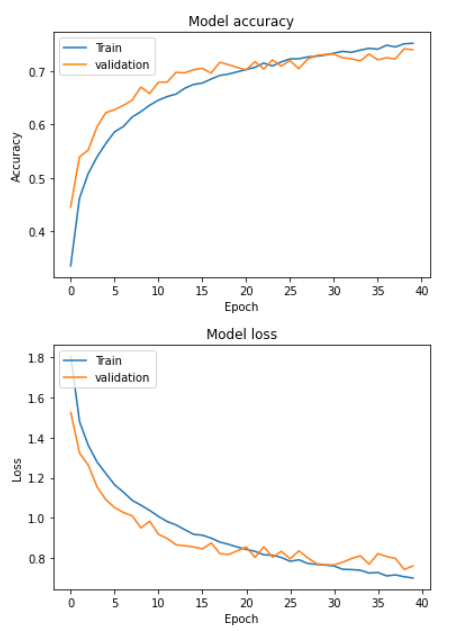

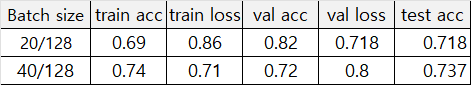

* 증식하기 전과 큰 차이가 없으며 단순 증식만으로 확률을 높이기 어렵다고 판단하였다.

##2.2 Mix up 증강

###2.2.1 Mix up 함수

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, batch_size = 1, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

* Mix up 학습 단계에서 두 개의 인풋 데이터를 랜덤으로 샘플링해서 새로운 인풋을 적절히 섞어서 만드는 기법이다. 
* 믹스업 기법을 적용하면 학습의 일반화에 도움을 준다고 한다.

###2.2.2 Mixup 샘플 확인 

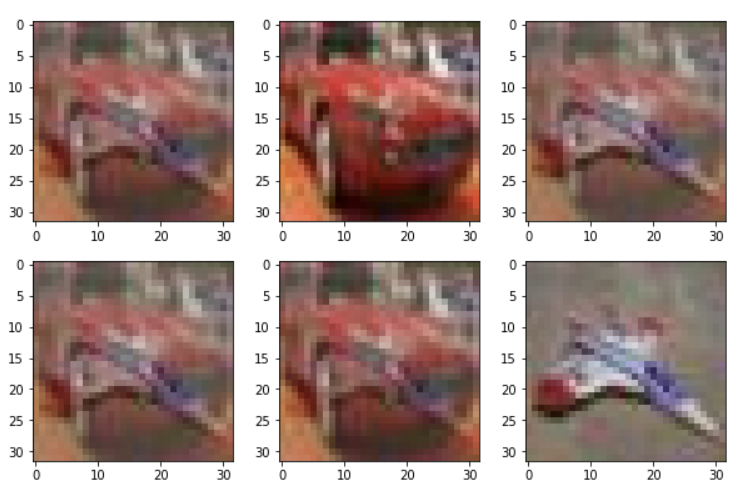

###2.2.3 one-hot-encoding 적용

mixup을 적용하기 위해 one-hot 기법을 적용해준다.

In [ ]:
import random
random.seed(42)
from sys import stdout

training_labels = tf.one_hot(training_labels, 10) 

mix_training_images = []
mix_training_labels = []

for i in range(3):
    random_num = random.sample(range(0,50000), 50000) 
    print("\nAttempt", i)
    progress_before = 0

    for i in range(0,50000,2):
        image_1 = training_images[random_num[i]]
        label_1 = training_labels[random_num[i]]

        image_2 = training_images[random_num[i+1]]
        label_2 = training_labels[random_num[i+1]]

        mix_image, mix_label = mix_up((image_1, label_1), (image_2, label_2))

        mix_training_images.append(mix_image[0])
        mix_training_labels.append(mix_label[0])
        
        #just for ui
        progress = int(100*(i/49998))
        if progress != progress_before:
            progress_before = progress
            stdout.write("\r ========= %d%% completed =========" %progress)
            stdout.flush()

mix_training_images = np.array(mix_training_images)
mix_training_labels = np.array(mix_training_labels)

###2.2.4 모델 설계 

In [ ]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer
    #tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

* 활성화함수는 역시 softmax, 최적화함수는 adam을 이용하였고 원핫인코딩 기법으로 바꾸었기 때문에 손실함수는 categorical crossentropy를 적용하였다.

###2.2.5 Mix up 결과

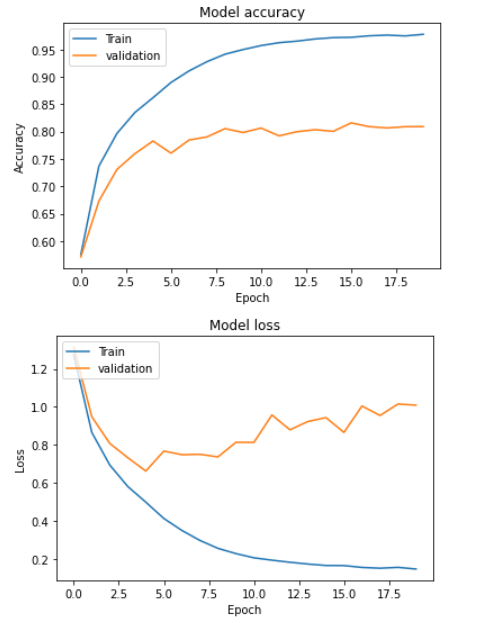

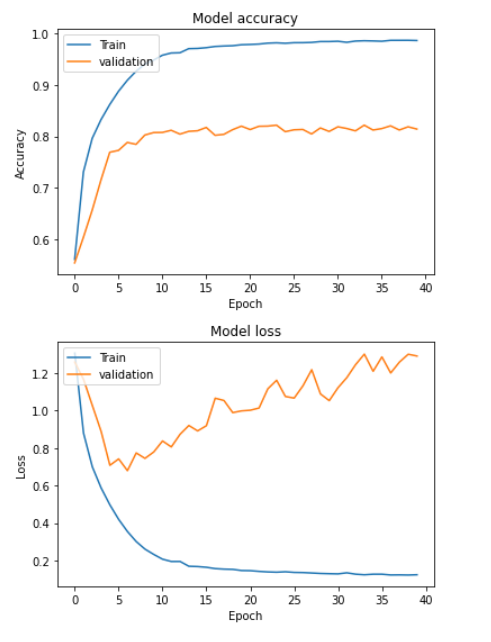

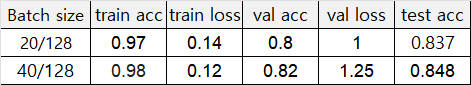

* 과적합은 보이지만 Mixup 적용 후 테스트 확률이 0.84정도까지 올라갔다.



#3.Mix up증강 + CNN 깊이 변화

##3.1 CNN 층의 변화 

###3.1.1 모델 설계

* convolution layer를 추가하여 network의 깊이를 더 깊게 만들었다.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer

    tf.keras.layers.Dense(256, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

###3.1.2 결과

 


 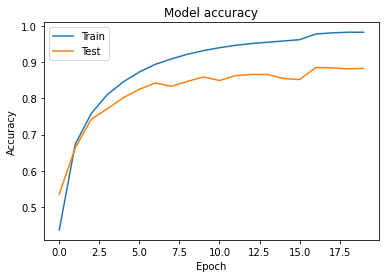
 

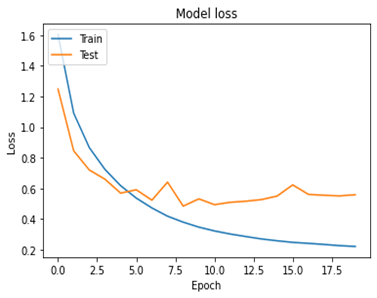



 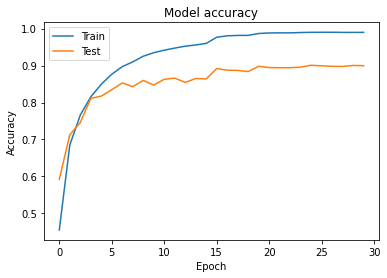
 

 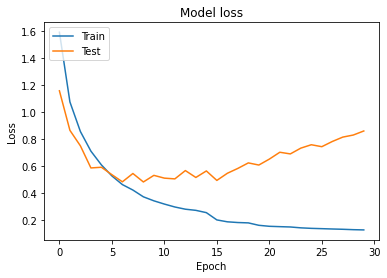

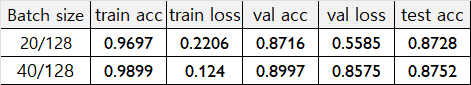

* 테스트 확률 0.8752로 Mixup 증강 + CNN 깊이 변화를 준 방법이 매우 효과적라 볼 수 있다.

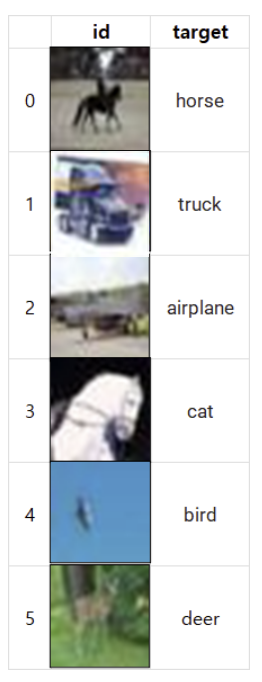

* 이미지 예측 프레임을 보면 말을 고양이로 예측하는 오류는 있지만 전체적으로 잘 예측함을 확인할 수 있다. 

#4.전이

전이 학습(Transfer Learning)은 특정 분야에서 학습된 신경망의 일부 능력을 유사하거나 전혀 새로운 분야에서 사용되는 신경망의 학습에 이용하는 것을 의미한다.

##4.1 VGG16 

* VGG-16은 ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 컨벌루션 신경망이다. 이 네트워크에는 16개의 계층이 있으며, 영상을 1,000가지 사물 범주로 분류할 수 있다.

###4.1.1 모델구조

* 합성곱 기반층 모습 

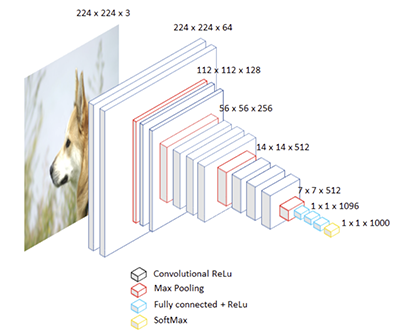

###4.1.2 모델 로드 

In [ ]:
img_shape = (img_height , img_width, 3)
# include_top = False인 경우 input_shape = img_size 지정 필요
# conv에 대한 가중치 학습이 없음
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')

###4.1.3 모델 설계 

In [ ]:
VGG16_MODEL.trainable=False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names),
                                         activation ='softmax' )

model = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])
# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습

In [ ]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

###4.1.4 결과 

- epoch : 10 / batch_size = 32

 - accuracy

 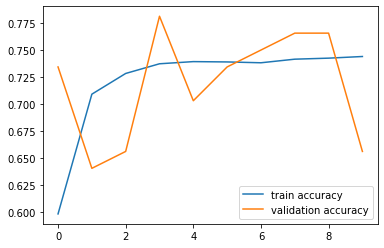
 - loss

 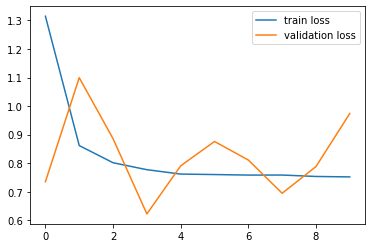

In [ ]:
Epoch 10/10
1250/1250 [==============================] - 103s 83ms/step - loss: 0.7520 - accuracy: 0.7440
 - val_loss: 0.9740 - val_accuracy: 0.6562

## 4.2 resnet50 v2

* ResNet-50은 50개 계층으로 구성된 컨벌루션 신경망이다. ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 신경망의 사전 훈련된 버전을 불러올 수 있다.

###4.2.1 모델 구조

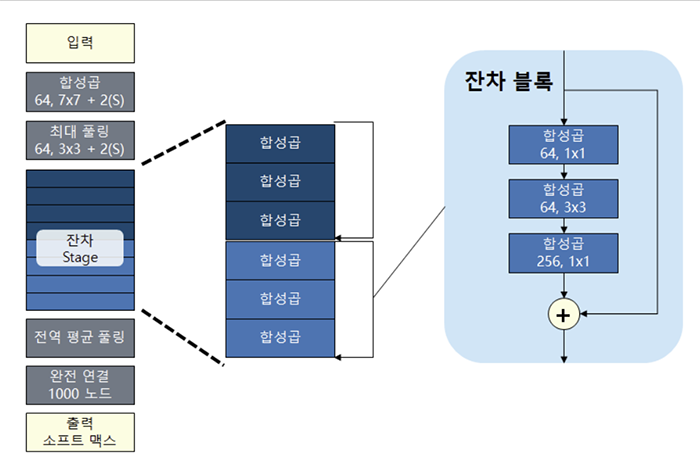


###4.2.2모델 로드 


In [ ]:
resnetv2 = tf.keras.applications.ResNet50V2(include_top=False,input_shape=(height,width,channels))


###4.2.3 모델 설계 

In [ ]:
resnetv2.trainable=False

In [ ]:
model = Sequential([
                 resnetv2,
                 Dense(512,activation='relu'),
                 BatchNormalization(),
                 GlobalAveragePooling2D(),
                 Dense(classes,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

### 4.2.4 결과

> epoch = 10 / batch_size = 32

```
Epoch 10/10
1250/1250 [==============================] - 95s 76ms/step - loss: 0.0153 - accuracy: 0.9973 
- val_loss: 0.7897 - val_accuracy: 0.8227 
```
>accuracy

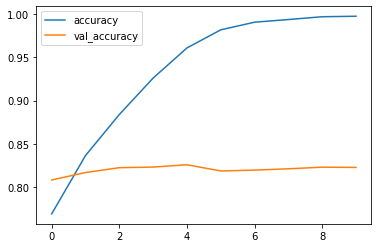
>loss

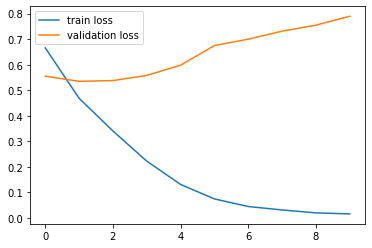



* 이와 같이 전이학습 2종류의 모델을 구현하였고 이 중 resnet50v2가 조금 가능성 있어보였으나 전체적으로 만족스러운 결과를 얻지 못하였다. 좀 더 다양한 전이학습 모델에 증강을 하여 비교하기로 하였다.

#5.데이터증강 + 전이학습
- 데이터를 증강하여 전이학습을 시도하였다
- 전체적인 과정은 아래와 같다.
  1. 데이터 전처리
  2. 14개 사전학습 모델을 평가
  3. 가장 효율적인 모델인 ResNet50V2를 미세조정하여 학습

## 5.1 데이터 전처리

- 데이터 증강은 회전, 확대 축소, 상하/좌우 이동, 좌우 반전을 사용하였다.

##5.2 전이학습
- 평가할 사전학습 모델은 아래와 같이 총 14개이다.
  - DenseNet121
  - DenseNet169
  - DenseNet201
  - EfficientNetB0
  - EfficientNetB1
  - InceptionV3
  - MobileNetV2
  - MobileNetV3Large
  - ResNet152V2
  - ResNet50
  - ResNet50V2
  - VGG19
  - VGG16
  - Xception

- 14개 사전학습 모델의 train/validation/test 손실과 정확도, 그래프, 학습 소요시간을 확인하고 표로 정리하였다.
- test accuracy가 0.8을 넘는 모델은 ResNet152V2, ResNet50V2였다.
- 학습시간이 1500초 미만인 모델은 EfficientNetB0, InceptionV3, MobileNetV2, MobileNetV2Large, ResNet50V2 이었다.
- 이 중에서 높은 test accuracy와 짧은 학습시간을 모두 만족하는 ResNet50V2가 가장 효율적인 모델이라 판단하였다.
- 따라서 ResNet50V2를 미세조정하여 정확도 향상을 시도해 보았다.

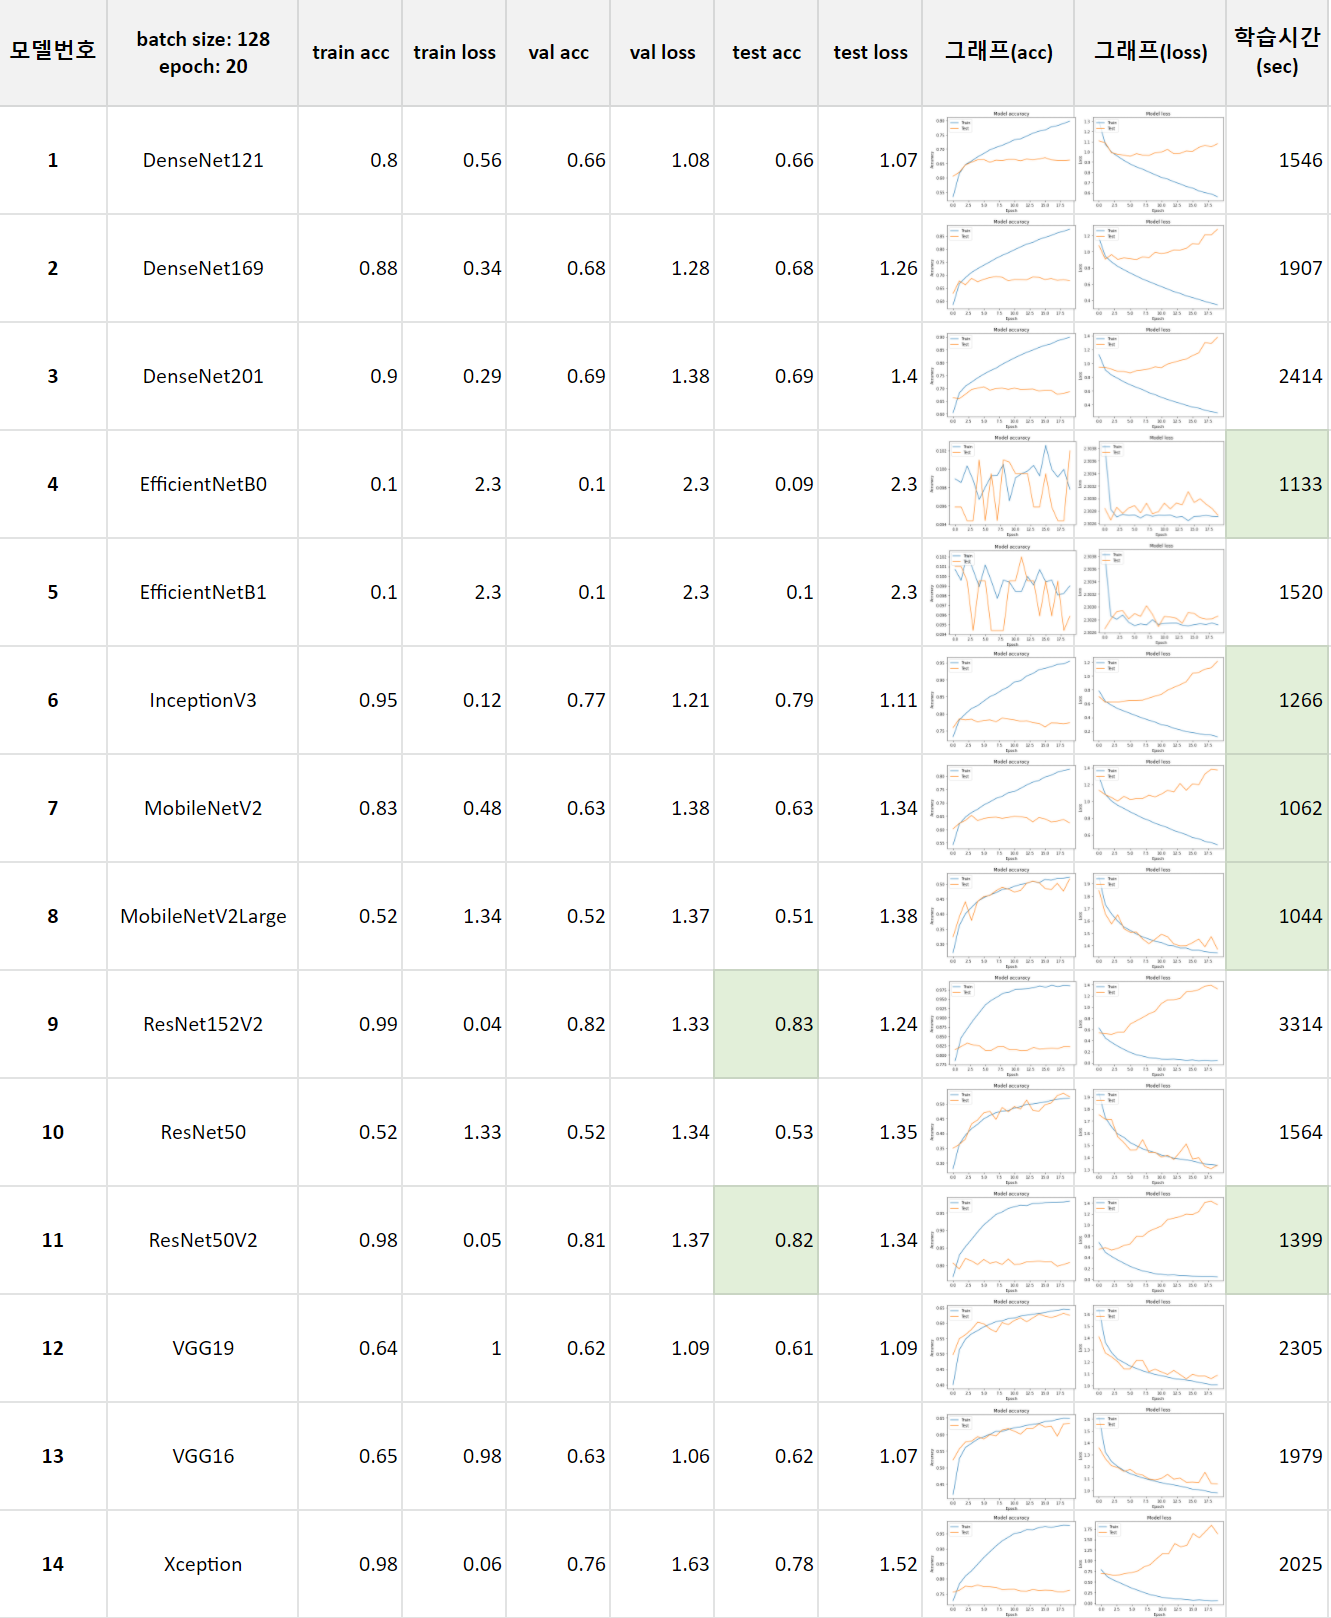

###5.2.1 미세조정
- ResNet50V2 미세조정의 과정은 아래와 같다.
  1. 사전학습된 ResNet50V2에 새로운 네트워크를 추가한다.
  2. ResNet50V2을 동결한다.
  3. 새로운 네트워크를 훈련한다.
  4. ResNet50V2에서 일부 층의 동결을 해제한다.
  5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련한다.

#### 1. ResNet50V2에 새로운 네트워크 추가

- 먼저 ResNet50V2를 base_model로 정의하고 구조를 살펴보았다.
  - 150개가 넘는 많은 층으로 이루어져 있으며, 크게 보면 5개의 convolution 층으로 나눠진다.
  - 나중에 일부 층의 동결을 해제할 때에는 마지막 conv5 층만 동결 해제하고 훈련시킬 예정이다.

In [ ]:
base_model = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_conv[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_preact_bn (BatchN  (None, 56, 56, 64)  256         ['pool1_pool[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 conv2_block1_preact_relu (Acti  (None, 56, 56, 64)  0           ['conv2_block1_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4096        ['conv2_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)
 ______________________________________________________________________________________                                                                                       
 ...(중간 생략)...
 ______________________________________________________________________________________
  conv5_block3_2_pad (ZeroPaddin  (None, 9, 9, 512)   0           ['conv5_block3_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359296     ['conv5_block3_2_pad[0][0]']     
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_conv[0][0]']    
                                                                                                  
 post_bn (BatchNormalization)   (None, 7, 7, 2048)   8192        ['conv5_block3_out[0][0]']       
                                                                                                  
 post_relu (Activation)         (None, 7, 7, 2048)   0           ['post_bn[0][0]']                
                                                                                                  
==================================================================================================
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
__________________________________________________________________________________________________

#### 2. ResNet50V2 동결
- base_model에 새로운 네트워크(완전 연결 분류기)를 추가하고, base_model을 동결시켰다.

In [ ]:
# base_model에 새로운 네트워크 추가
x = base_model.output
x = layers.AveragePooling2D(pool_size=(7, 7))(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

# base_model을 동결
for layer in base_model.layers:
  layer.trainable = False

#### 3. 새로운 네트워크 훈련
- 전처리된 데이터를 이용하여 새로운 네트워크를 훈련시킨다.
- 0.83의 테스트 정확도가 나왔다.

In [ ]:
hist = model.fit(train_images, validation_data=val_images, epochs=20, batch_size=128)

test_loss, test_acc = model.evaluate_generator(test_images, steps=50)
print('test loss:', test_loss)
print('test accuracy:', test_acc)

In [ ]:
Epoch 20/20
1000/1000 [==============================] - 113s 113ms/step - loss: 0.2325 - accuracy: 0.9158 
- val_loss: 0.6952 - val_accuracy: 0.8226
test loss: 0.5989950895309448
test accuracy: 0.8387500047683716

#### 4. ResNet50V2의 일부 층 동결 해제

- 먼저 전체 층의 동결을 해제한다.

In [ ]:
base_model.trainable = True

- 전체 동결 해제 후 훈련가능한 가중치는 총 176개로 나타난다.

In [ ]:
len(model.trainable_weights)

176

- 다시 ResNet50V2의 층 중 conv5 층을 제외한  층을 동결한다.
- 이제 훈련 가능한 가중치는 38개이다.

In [ ]:
# conv5층 제외하고 동결
set_trainable = False
for layer in base_model.layers:
  if layer.name == 'conv5_block1_preact_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

# 훈련가능한 층 확인
len(model.trainable_weights)

38

#### 5. 동결 해제 층과 새로 추가한 층을 함께 훈련

- 1차 미세조정
  - ResNet50V2의 conv5 층과 새로운 네트워크 층을 함께 훈련시켰다.
  - optimizer: Adam
  - learning rate: 0.0001
  - batch_size: 16
  - epochs: 20
- 결과는 과적합된 양상을 보이지만 0.89의 테스트 정확도를 달성했고 테스트 손실은 0.55로 나타났다.

In [ ]:
hist = model.fit(train_images, validation_data=val_images, epochs=20, batch_size=16)

test_loss, test_acc = model.evaluate_generator(test_images, steps=50)
print('test loss:', test_loss)
print('test accuracy:', test_acc)

In [ ]:
Epoch 20/20
1000/1000 [==============================] - 149s 149ms/step - loss: 0.0292 - accuracy: 0.9914
 - val_loss: 0.5940 - val_accuracy: 0.8849
test loss: 0.5514243841171265
test accuracy: 0.8918750286102295
trained in 2975.14 sec

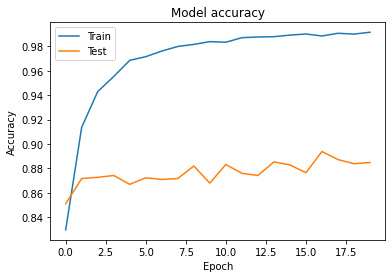

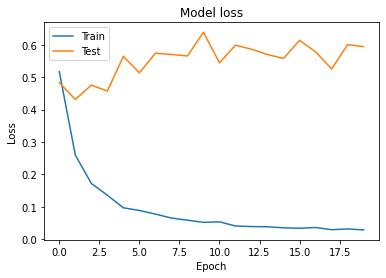

- 2차 미세조정 결과
  - 이번에는 optimizer로 SGD를 사용했다.
  - optimizer: SGD
  - learning rate: 0.0001
  - batch_size: 16
  - epochs: 20
- 테스트 정확도는 0.89로 Adam 사용시와 비슷으나 손실은 0.39로 더 좋은 결과를 나타냈다. 또한 더 안정적인 양상의 손실, 정확도 그래프를 보여주었다.

In [ ]:
hist = model1.fit(train_images, validation_data=val_images, epochs=20, batch_size=16)

In [ ]:
Epoch 20/20
1000/1000 [==============================] - 84s 84ms/step - loss: 0.2667 - accuracy: 0.9051 
- val_loss: 0.3838 - val_accuracy: 0.8831
test loss: 0.39223602414131165
test accuracy: 0.8862500190734863
trained in 1759.52 sec

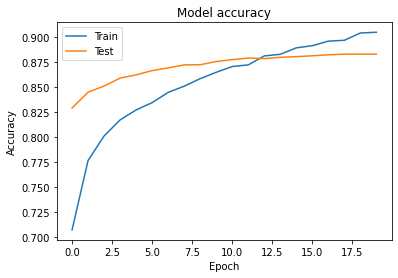

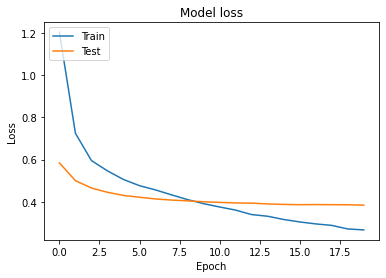



---



# III.결론

##1.결과 
이와 같이 증강과 전이 그리고 증강+전이학습에 대하여 알아 보았다.

본 데이터에는 전이학습보다는 증강학습이 더 효과적이었고 추가적으로  믹스업증강이나 CNN레이어 변화와 같은 다양한 방법을 더하여 더욱 좋은 결과를 냈음을 알 수 있었다.

또한 데이콘에는 사전학습 모델은 금지되어있어 증강한 모델을 위주로 확률을 높이기 위해 노력하였다.

증강+믹스업+CNN 층 변화를 준 모델 (test accuracy 0.87) 데이콘 대회에 제출하였다.

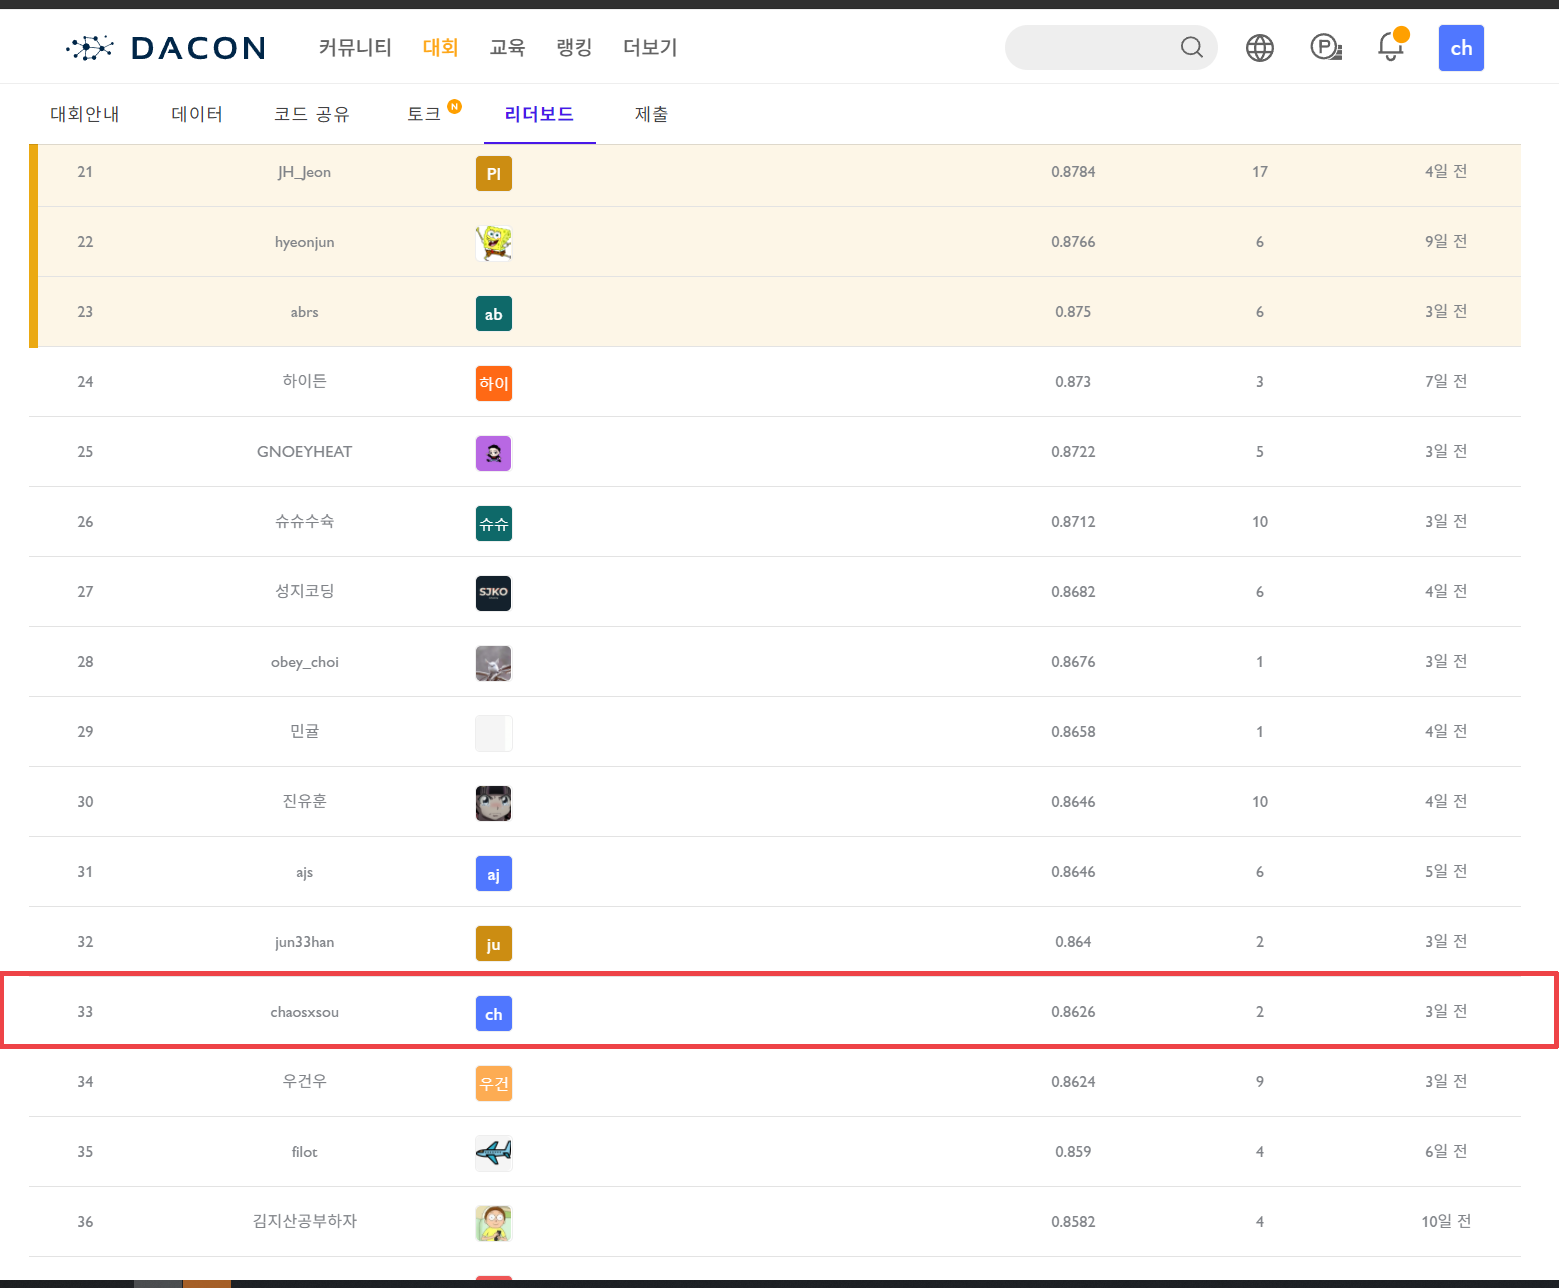

전체 참여인원 235명 중 33위로 상위 14프로의 결과를 낼 수 있어 목표 달성하였다.





## 2.향후 개선 사항 및 아쉬운 점



*   모델 구현에 많은 시간이 들었으며 프로젝트 시간이 길지 않았다.
*   5만개가 넘는 이미지를 테스트하기에 구축환경이 좋지 못하였다.
*   팀원의 수가 적었다.
*   CNN관련 지식이 많이 깊지 못하여 추후에 좀 더 학습하여 더욱 완벽한 모델을 구축하고자 하는 바람이다.
  



#Thank you!!